# Predicting Kills and Headshots for CS

**Goal**: Predict the kills and headshots for a player's next game using historical HLTV data.

## Definitions

- **Rating**: A metric calculated by comparing a player's average stats:
  - Kills per round
  - Survived rounds per round
  - Number of rounds with multiple kills
  
- **KAST**: The percentage of rounds where a player contributes in one or more of the following ways:
  - Killing an enemy
  - Assisting a teammate
  - Surviving a round
  - Getting revenge on an enemy (trading for a teammate's death)

- **K-D Diff**: The difference between kills and deaths (Kills - Deaths).

- **ADR**: The average damage per round, measuring the damage output of a player.

- **FK Diff**: The difference in first kills (positive or negative) a player contributes, often reflecting early-round aggression.


In [67]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings, json, joblib

from scipy.stats import f_oneway
import category_encoders as ce

# Machine learning
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

## Import Data

In [2]:
# Import player ranks (Ordered from best to worse)
top_players_2024 = json.load(open("./player_ranks/2024.json"))["2024"]
top_players_2023 = json.load(open("./player_ranks/2023.json"))["2023"]

In [3]:
# Import team ranks (Ordered from best to worse)
top_teams_2024 = json.load(open("./team_ranks/2024.json"))["2024"]
top_teams_2023 = json.load(open("./team_ranks/2023.json"))["2023"]

In [4]:
# Load dataframes for both years
df1 = pd.read_csv("./data/2024.csv", index_col=[0])
df2 = pd.read_csv("./data/2023.csv", index_col=[0])

# Concat the data to a single dataframe
cs_data = pd.concat([df1, df2], ignore_index=True)

cs_data.head()

,Event,Date,Map,Map Number,Team,Name,Kills,Headshots,Assists,Deaths,...,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5,Teammate 5,Opponent 6,Opponent 7,Teammate 6
0,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,kralz,30,10,13,29,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
1,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,N2o,35,9,7,32,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
2,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,laxiee,27,15,14,32,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
3,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,obi,25,12,12,30,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
4,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,kmrn,24,14,6,29,...,obi,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN


In [5]:
# Convert data to datetime
cs_data["Date"] = pd.to_datetime(cs_data["Date"])

In [6]:
# Unique teams and players
team_df = cs_data[["Date", "Name", "Team"]].drop_duplicates()
team_df.reset_index(drop=True, inplace=True)
team_df.head()

,Date,Name,Team
0,2024-09-21 21:30:00,kralz,Akimbo
1,2024-09-21 21:30:00,N2o,Akimbo
2,2024-09-21 21:30:00,laxiee,Akimbo
3,2024-09-21 21:30:00,obi,Akimbo
4,2024-09-21 21:30:00,kmrn,Akimbo


In [7]:
# Concat the data
cs_data = \
cs_data.merge(
    right=team_df.add_prefix("Opponent "),
    left_on=["Date", "Opponent 1"],
    right_on=["Opponent Date", "Opponent Name"],
    how="left",
).drop(columns=["Opponent Date", "Opponent Name"])

# Opponents
opponents = cs_data.pop("Opponent Team")

# Append back to the dataframe
cs_data.insert(5, "Opponent Team", opponents)

cs_data.head()

,Event,Date,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5,Teammate 5,Opponent 6,Opponent 7,Teammate 6
0,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kralz,30,10,13,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
1,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,N2o,35,9,7,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
2,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,laxiee,27,15,14,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
3,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,obi,25,12,12,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
4,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kmrn,24,14,6,...,obi,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN


In [8]:
# Info on the dataframe
cs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303041 entries, 0 to 303040
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Event           303041 non-null  object        
 1   Date            303041 non-null  datetime64[ns]
 2   Map             303041 non-null  object        
 3   Map Number      303041 non-null  object        
 4   Team            303041 non-null  object        
 5   Opponent Team   303041 non-null  object        
 6   Name            303041 non-null  object        
 7   Kills           303041 non-null  int64         
 8   Headshots       303041 non-null  int64         
 9   Assists         303041 non-null  int64         
 10  Deaths          303041 non-null  int64         
 11  Kast            303041 non-null  object        
 12  K-D Diff        303041 non-null  int64         
 13  ADR             303041 non-null  object        
 14  FK Diff         303041 non-null  int

In [9]:
# Change the Dtype of the KAST and ADR columns
cs_data["Kast"] = cs_data["Kast"].str.replace("%", "").astype("float64")
cs_data["ADR"] = pd.to_numeric(cs_data["ADR"].astype(str).str.replace("-", ""), errors='coerce')

In [10]:
# Number of unique players
print(f"There's {len(cs_data["Name"].unique())} unique players")

There's 4290 unique players


In [11]:
# Number of unique teams
print(f"There's {len(cs_data["Team"].unique())} unique teams")

There's 1279 unique teams


In [12]:
# Number of games played in the last two years by a gamer
cs_data["Name"].value_counts()

Name
Lucky          1082
bnox            673
brutmonster     672
simke           672
nEMANHA         670
               ... 
Sandraum          1
648               1
Strauchanie       1
risen             1
Bubzkji           1
Name: count, Length: 4290, dtype: int64

In [13]:
# Maps played in the last two years
cs_data["Map"].value_counts()

Map
Ancient      55562
Mirage       48386
Anubis       43639
Inferno      42938
Nuke         40834
Vertigo      32411
Overpass     29441
Dust2         9460
Best of 3      310
Best of 2       20
Train           20
Cache           10
All             10
Name: count, dtype: int64

## Exploratory Data Analaysis

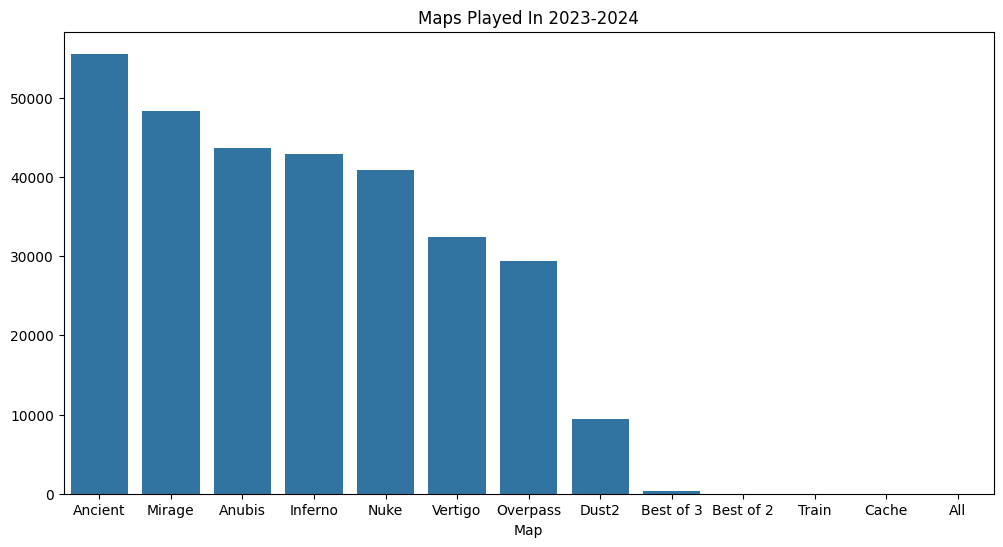

In [14]:
# Visual of the data
plt.figure(figsize=(12, 6))
sns.barplot(x=cs_data["Map"].value_counts().keys(), y=cs_data["Map"].value_counts().values)
plt.title("Maps Played In 2023-2024")
plt.show()

In [15]:
# Store the stats only as a dataframe
cs_stats = cs_data.iloc[:, :].query("(Map!='Best of 3') and (Map!='Best of 2') and (Map!= 'All') and (Map!='Train') and (Map!='Cache') and (Map!='Overpass')").reset_index(drop=True)
cs_stats.head()

,Event,Date,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5,Teammate 5,Opponent 6,Opponent 7,Teammate 6
0,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kralz,30,10,13,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
1,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,N2o,35,9,7,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
2,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,laxiee,27,15,14,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
3,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,obi,25,12,12,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
4,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kmrn,24,14,6,...,obi,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN


In [16]:
# Map values after querying
cs_stats["Map"].value_counts()

Map
Ancient    55562
Mirage     48386
Anubis     43639
Inferno    42938
Nuke       40834
Vertigo    32411
Dust2       9460
Name: count, dtype: int64

In [17]:
# Get info on the data after query filtering
cs_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273230 entries, 0 to 273229
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Event           273230 non-null  object        
 1   Date            273230 non-null  datetime64[ns]
 2   Map             273230 non-null  object        
 3   Map Number      273230 non-null  object        
 4   Team            273230 non-null  object        
 5   Opponent Team   273230 non-null  object        
 6   Name            273230 non-null  object        
 7   Kills           273230 non-null  int64         
 8   Headshots       273230 non-null  int64         
 9   Assists         273230 non-null  int64         
 10  Deaths          273230 non-null  int64         
 11  Kast            273230 non-null  float64       
 12  K-D Diff        273230 non-null  int64         
 13  ADR             273214 non-null  float64       
 14  FK Diff         273230 non-null  int

In [18]:
# Drop the missing ADR values
cs_stats = cs_stats.dropna(axis=1).reset_index(drop=True)

In [19]:
# Missing values
cs_stats.isna().sum()

Event             0
Date              0
Map               0
Map Number        0
Team              0
Opponent Team     0
Name              0
Kills             0
Headshots         0
Assists           0
Deaths            0
Kast              0
K-D Diff          0
FK Diff           0
Rating            0
Team Score        0
Opponent Score    0
Teammate 1        0
Teammate 2        0
Teammate 3        0
Teammate 4        0
Opponent 1        0
Opponent 2        0
Opponent 3        0
Opponent 4        0
Opponent 5        0
dtype: int64

In [20]:
# Describe the data
cs_stats.drop("Date", axis=1).describe().round(3)

,Kills,Headshots,Assists,Deaths,Kast,K-D Diff,FK Diff,Rating,Team Score,Opponent Score
count,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000
mean,15.773,7.729,4.689,15.879,70.783,-0.106,-0.004,1.063,11.852,11.853
std,6.012,3.770,2.645,4.718,11.859,6.357,2.292,0.329,4.254,4.254
min,0.000,0.000,0.000,0.000,7.100,-29.000,-14.000,0.040,0.000,0.000
25%,12.000,5.000,3.000,13.000,63.300,-5.000,-1.000,0.840,9.000,9.000
50%,15.000,7.000,4.000,16.000,71.400,0.000,0.000,1.040,13.000,13.000
75%,19.000,10.000,6.000,19.000,78.900,4.000,1.000,1.260,16.000,16.000
max,63.000,38.000,28.000,58.000,100.000,29.000,13.000,3.150,37.000,37.000


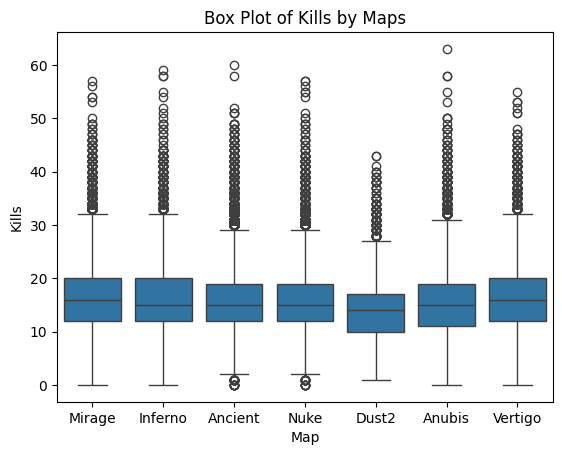

In [21]:
# Distribution of kills by maps
sns.boxplot(data=cs_stats, x="Map", y="Kills")
plt.title("Box Plot of Kills by Maps")
plt.show()

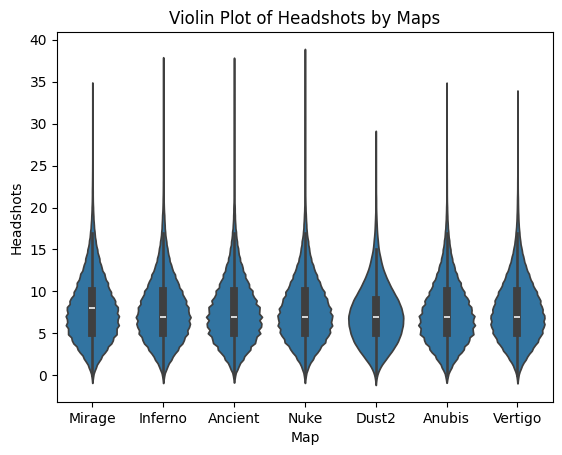

In [22]:
# Distribution of headshots by maps
sns.violinplot(data=cs_stats, x="Map", y="Headshots")
plt.title("Violin Plot of Headshots by Maps")
plt.show()

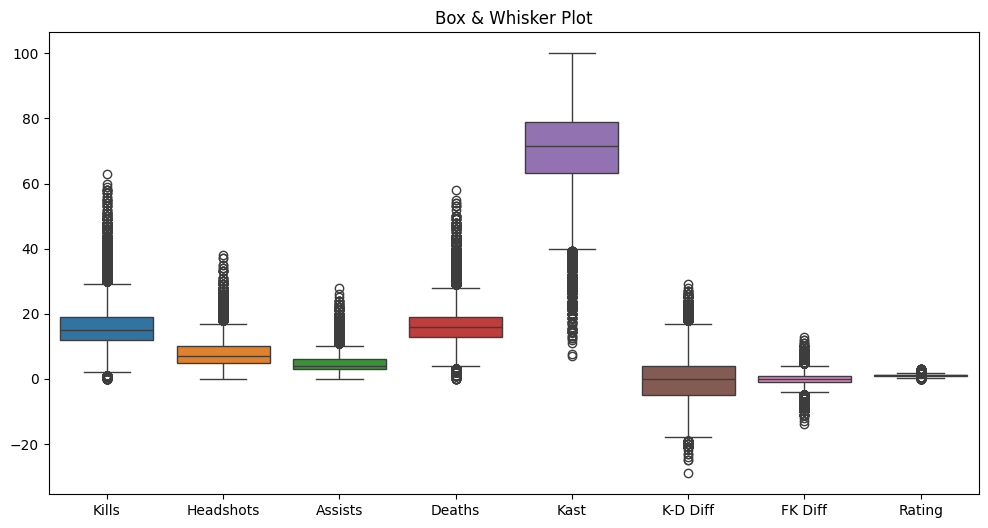

In [23]:
# Box & Whisker Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=cs_stats.drop(columns=["Team Score", "Opponent Score"]))
plt.title("Box & Whisker Plot")
plt.show()

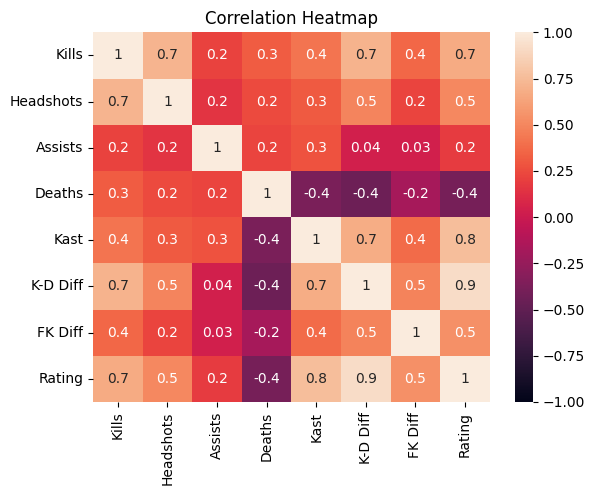

In [24]:
# Correlation matrix
corr_matrix = cs_stats.drop(columns=["Team Score", "Opponent Score"]).corr(numeric_only=True)

# Plot Heatmap
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".1g")
plt.title("Correlation Heatmap")
plt.show()

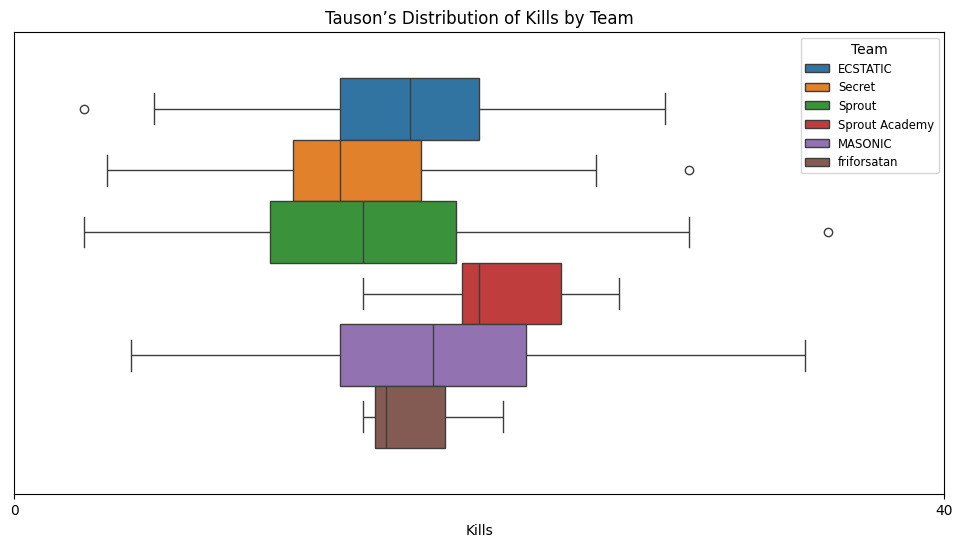

In [25]:
# Data for the player Tauson
tauson_data = cs_data[cs_data["Name"]=="Tauson"].drop(columns=["Team Score", "Opponent Score"])

# Plot
plt.figure(figsize=(12, 6))
plt.title("Tauson’s Distribution of Kills by Team")

# Box Plot
sns.boxplot(data=tauson_data, x="Kills", hue="Team")

# Adjust the legend
plt.legend(title="Team", loc="upper right", fontsize='small', title_fontsize='medium')

# Adjust ticks
plt.yticks([])
plt.xticks(ticks=(0, 40))

# Display the plot
plt.show()

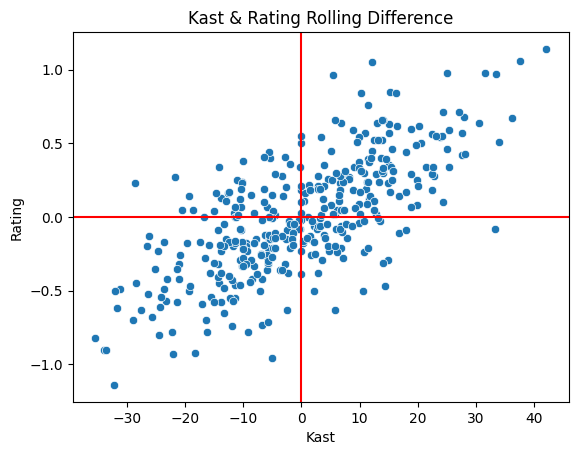

In [26]:
# Plot the relationship between Kast and Rating
sns.scatterplot(data=tauson_data[["Kast", "Rating"]].diff(), x="Kast", y="Rating")
plt.axhline(0, c="r")
plt.axvline(0, c="r")
plt.title("Kast & Rating Rolling Difference")
plt.show()

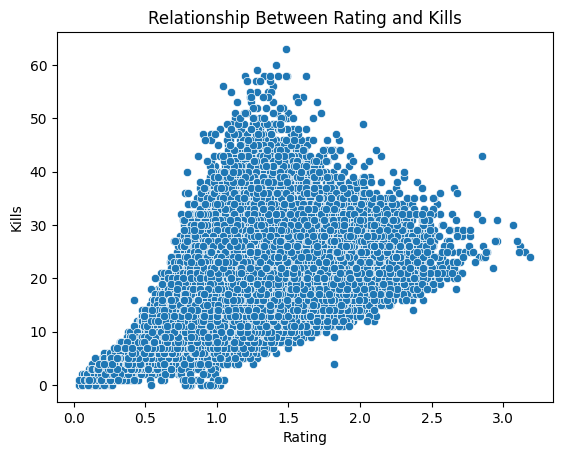

In [27]:
sns.scatterplot(data=cs_data, x="Rating", y="Kills")
plt.title("Relationship Between Rating and Kills")
plt.show()

## Data Preprocessing

- Calculate
    - **K/D ratio**
    - **Date** (Month & Year)

- Drop Columns
    - **Event**
    - **Team & Opponent Score**

- Encode
    - **Group Players**
    - **Group Teams**

In [28]:
# Filter to players that played at least 100 games with a team
cs_stats_f = cs_stats.groupby(["Name", "Team"]).filter(lambda group: len(group)>=100)
cs_stats_f.reset_index(drop=True, inplace=True)

In [29]:
# Calculate the K/D Ratio (replace 0's with 1)
cs_stats_f.insert(12, "K/D Ratio", cs_stats_f["Kills"]/(cs_stats_f["Deaths"].replace(0, 1)))
cs_stats_f.head()

,Event,Date,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Opponent Score,Teammate 1,Teammate 2,Teammate 3,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5
0,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,timbermen,BOSS,snav,13,7,7,...,16,shane,intra,dea,dare,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
1,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,timbermen,BOSS,dare,11,3,10,...,16,shane,intra,dea,snav,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
2,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,BOSS,timbermen,freshie,30,7,3,...,14,Fruitcupx,SLIGHT,d4rty,Cryptic,shane,intra,dea,snav,dare
3,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,BOSS,timbermen,d4rty,21,7,8,...,14,freshie,Fruitcupx,SLIGHT,Cryptic,shane,intra,dea,snav,dare
4,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,BOSS,timbermen,Cryptic,18,6,10,...,14,freshie,Fruitcupx,SLIGHT,d4rty,shane,intra,dea,snav,dare


In [30]:
# Get the month and year from the date column
cs_stats_f.insert(2, "Month", cs_stats_f["Date"].dt.month_name())
cs_stats_f.insert(3, "Year", cs_stats_f["Date"].dt.year)

In [31]:
# Replace values from the map numbers
cs_stats_f["Map Number"] = cs_stats_f["Map Number"].replace("Single Map", 0)

In [32]:
# Dropping columns
cs_stats_f.drop(["Event", "Date", "Team Score", "Opponent Score"], axis=1, inplace=True)
cs_stats_f.head()

,Month,Year,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Rating,Teammate 1,Teammate 2,Teammate 3,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5
0,September,2024,Anubis,1,timbermen,BOSS,snav,13,7,7,...,0.80,shane,intra,dea,dare,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
1,September,2024,Anubis,1,timbermen,BOSS,dare,11,3,10,...,0.62,shane,intra,dea,snav,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
2,September,2024,Anubis,1,BOSS,timbermen,freshie,30,7,3,...,1.45,Fruitcupx,SLIGHT,d4rty,Cryptic,shane,intra,dea,snav,dare
3,September,2024,Anubis,1,BOSS,timbermen,d4rty,21,7,8,...,1.13,freshie,Fruitcupx,SLIGHT,Cryptic,shane,intra,dea,snav,dare
4,September,2024,Anubis,1,BOSS,timbermen,Cryptic,18,6,10,...,1.11,freshie,Fruitcupx,SLIGHT,d4rty,shane,intra,dea,snav,dare


In [33]:
# Weighted moving average (weights)
weights = np.array([0.25, 0.20, 0.15, 0.125, 0.115, 0.10, 0.05, 0.01])

# Window size
n = 8

# Columns to apply weighted moving averages
weight_cols = ["Kills", "Headshots", "Assists", "Deaths", "Kast", "K/D Ratio", "K-D Diff", "FK Diff", "Rating"]

# Group by an individual and the map they played on
wma_g = cs_stats_f.groupby(["Name", "Map"])[weight_cols].rolling(n, closed="left").apply(lambda group: np.dot(weights[::-1], group), raw=True)

In [34]:
# Reset the index and make sure it aligns with the dataframe
wma_g = wma_g.add_prefix("WMA ").reset_index().set_index("level_2").sort_index()

In [35]:
# Drop null values
wma_g.dropna(inplace=True)

# Merge the old dataframe with the WMA's
cs_stats_wma = pd.merge(
    left=cs_stats_f,
    right=wma_g.drop(columns=["Name", "Map"]),
    left_index=True,
    right_index=True
)

# Reset the index for the merged data
cs_stats_wma.reset_index(drop=True, inplace=True)

cs_stats_wma.head()

,Month,Year,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Opponent 5,WMA Kills,WMA Headshots,WMA Assists,WMA Deaths,WMA Kast,WMA K/D Ratio,WMA K-D Diff,WMA FK Diff,WMA Rating
0,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,lov1kus,17,10,4,...,Tapewaare,12.335,4.745,4.740,12.940,67.9620,1.035473,-0.605,-1.305,1.01975
1,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,FenomeN,12,3,1,...,Tapewaare,15.030,5.170,3.180,12.735,76.4065,1.357438,2.295,0.730,1.18975
2,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,sstiNiX,15,8,5,...,Tapewaare,19.510,11.005,2.940,12.770,71.8015,1.642299,6.740,0.930,1.44520
3,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,levantino,12,9,6,...,Tapewaare,14.430,8.470,5.870,14.005,72.1840,1.144623,0.425,-0.285,1.14805
4,September,2024,Ancient,2,CPH Wolves,DMS,szejn,13,6,3,...,sFade8,19.280,10.145,8.745,17.000,72.7470,1.202604,2.280,1.510,1.26385


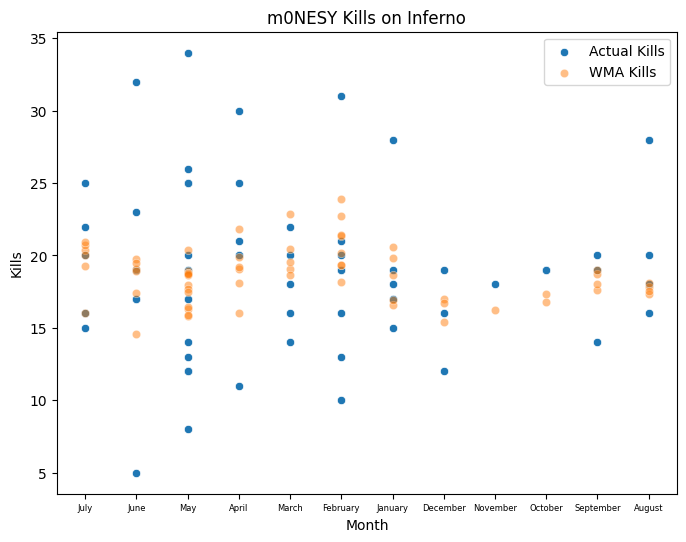

In [36]:
# Let's try to see how well the WMA line fits using m0NESY
m0NESY_inferno = cs_stats_wma[(cs_stats_wma["Name"]=="m0NESY") & (cs_stats_wma["Map"]=="Inferno")]

plt.figure(figsize=(8, 6))
plt.title("m0NESY Kills on Inferno")
# Actual kills
sns.scatterplot(data=m0NESY_inferno, x="Month", y="Kills", label="Actual Kills")

# WMA kills
sns.scatterplot(data=m0NESY_inferno, x="Month", y="WMA Kills", label="WMA Kills", alpha=0.5)

# Change tick size and add legend
plt.xticks(fontsize=6)
plt.legend()
plt.show()

## Encoding

In [37]:
# Need to convert these columns to numerical values for the ML model
cs_stats_wma.select_dtypes("object")

,Month,Map,Map Number,Team,Opponent Team,Name,Teammate 1,Teammate 2,Teammate 3,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5
0,September,Anubis,1,CYBERSHOKE,CPH Wolves,lov1kus,notineki,FenomeN,sstiNiX,levantino,Fessor,szejn,eraa,sausol,Tapewaare
1,September,Anubis,1,CYBERSHOKE,CPH Wolves,FenomeN,lov1kus,notineki,sstiNiX,levantino,Fessor,szejn,eraa,sausol,Tapewaare
2,September,Anubis,1,CYBERSHOKE,CPH Wolves,sstiNiX,lov1kus,notineki,FenomeN,levantino,Fessor,szejn,eraa,sausol,Tapewaare
3,September,Anubis,1,CYBERSHOKE,CPH Wolves,levantino,lov1kus,notineki,FenomeN,sstiNiX,Fessor,szejn,eraa,sausol,Tapewaare
4,September,Ancient,2,CPH Wolves,DMS,szejn,sausol,eraa,Tapewaare,Fessor,AW,kAlash,sm3t,molodoy,sFade8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122400,January,Ancient,2,iNation,Monte,choiv7,VLDN,Dragon,Kind0,DEPRESHN,rallen,Woro2k,BOROS,kRaSnaL,DemQQ
122401,January,Ancient,2,iNation,Monte,Kind0,VLDN,Dragon,choiv7,DEPRESHN,rallen,Woro2k,BOROS,kRaSnaL,DemQQ
122402,January,Anubis,1,NAVI Junior,Lazer Cats,dem0n,UNBR0KEN,rendY,froz1k,yab0ku-,munch,Burmylov,t0kk,m1she4ka,Hkta
122403,January,Mirage,2,NAVI Junior,Lazer Cats,dem0n,UNBR0KEN,rendY,froz1k,yab0ku-,Burmylov,m1she4ka,munch,Hkta,t0kk


In [38]:
# Encode the month column
months_encoded = pd.get_dummies(cs_stats_wma["Month"], dtype="int")

# Encode the year column
years_encoded = pd.get_dummies(cs_stats_wma["Year"], dtype="int")

In [39]:
# Encode the map column
maps_encoded = pd.get_dummies(cs_stats_wma["Map"], dtype="int")

In [40]:
# Encode the map number column
map_nums_encoded = pd.get_dummies(cs_stats_wma["Map Number"], dtype="int")

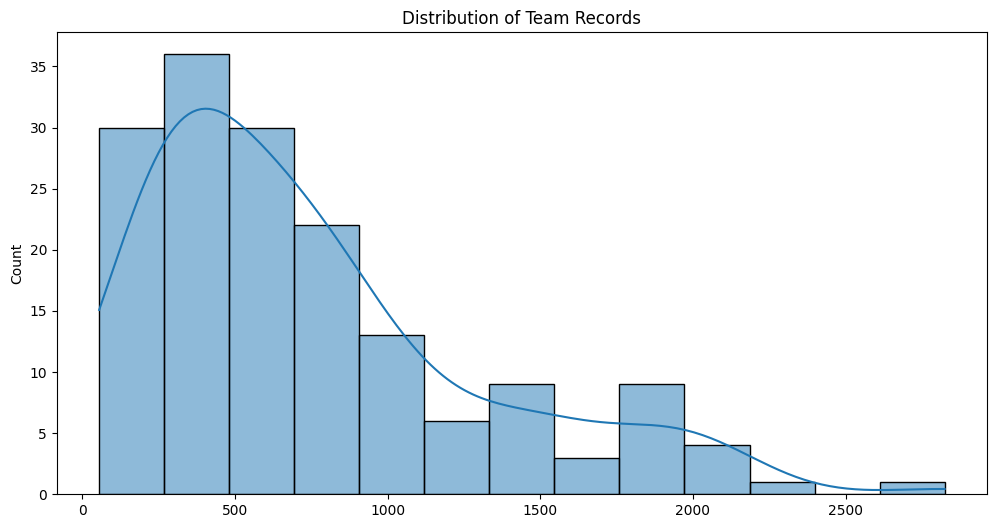

In [41]:
# Count the length of records for a team
record_team_counts = cs_stats_wma.groupby("Team").apply(lambda row: len(row)).sort_values()

# Plot it as a distribution
plt.figure(figsize=(12, 6))
plt.title("Distribution of Team Records")
sns.histplot(record_team_counts, kde=True)
plt.show()

In [42]:
# Initalize the encoder and add a smoother
tar_enc_team = ce.MEstimateEncoder(cols=["Team", "Opponent Team"], m=50)

# Encode only the names of the players
X = cs_stats_wma[["Team", "Opponent Team"]]
y = cs_stats_wma["Kills"]

# Fit and transform the model
tar_enc_team.fit(X, y)

MEstimateEncoder(cols=['Team', 'Opponent Team'], m=50)

In [43]:
# Transform team columns
tar_trans_teams = tar_enc_team.transform(cs_stats_wma[["Team", "Opponent Team"]])

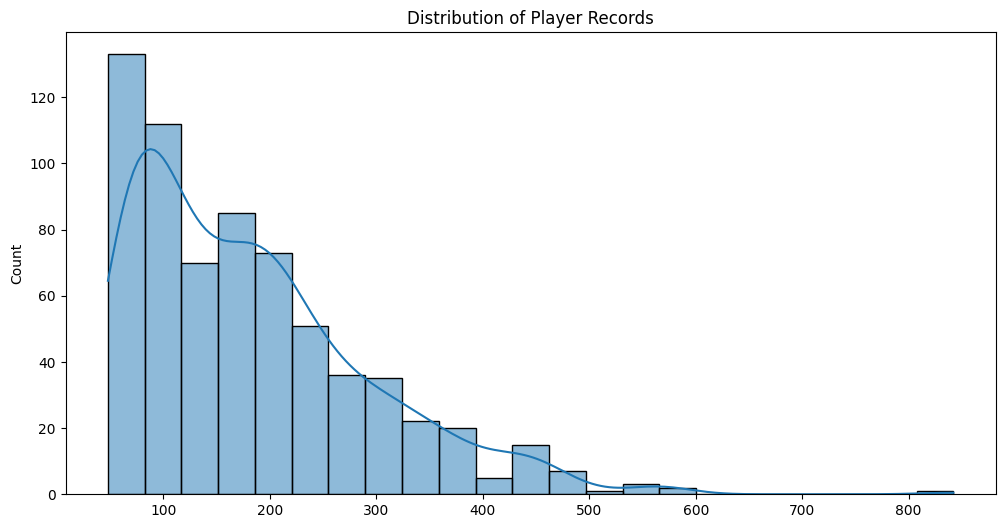

In [44]:
# Count the length of records for a player
record_player_counts = cs_stats_wma.groupby("Name").apply(lambda row: len(row)).sort_values()

# Plot it as a distribution
plt.figure(figsize=(12, 6))
plt.title("Distribution of Player Records")
sns.histplot(record_player_counts, kde=True)
plt.show()

In [45]:
player_cols = list(cs_stats_wma.select_dtypes("object").columns)[5:]

In [46]:
# Initalize the encoder and add a smoother
tar_enc_player = ce.MEstimateEncoder(cols=player_cols, m=100)

# Encode only the names of the players
X = cs_stats_wma[player_cols]
y = cs_stats_wma["Kills"]

# Fit and transform the model
tar_enc_player.fit(X, y)

MEstimateEncoder(cols=['Name', 'Teammate 1', 'Teammate 2', 'Teammate 3',
                       'Teammate 4', 'Opponent 1', 'Opponent 2', 'Opponent 3',
                       'Opponent 4', 'Opponent 5'],
                 m=100)

In [47]:
# Transform player columns
tar_trans_players = tar_enc_player.transform(cs_stats_wma[player_cols])

In [48]:
# Store the WMA's as a datframe
wma_clean = cs_stats_wma[
        [
        'Kills', 'Headshots',
        'WMA Kills', 'WMA Headshots', 'WMA Assists', 'WMA Deaths', 'WMA Kast',
        'WMA K-D Diff', 'WMA FK Diff', 'WMA Rating'
        ]
    ]

In [49]:
# Build the ML model dataframe
ml_df = pd.concat(
    [
        months_encoded,
        years_encoded,
        map_nums_encoded,
        tar_trans_teams,
        tar_trans_players,
        wma_clean
    ],
    axis=1
)

# Make sure the columns are strings
ml_df.columns = ml_df.columns.astype("str")
ml_df.head()

,April,August,December,February,January,July,June,March,May,November,...,Kills,Headshots,WMA Kills,WMA Headshots,WMA Assists,WMA Deaths,WMA Kast,WMA K-D Diff,WMA FK Diff,WMA Rating
0,0,0,0,0,0,0,0,0,0,0,...,17,10,12.335,4.745,4.740,12.940,67.9620,-0.605,-1.305,1.01975
1,0,0,0,0,0,0,0,0,0,0,...,12,3,15.030,5.170,3.180,12.735,76.4065,2.295,0.730,1.18975
2,0,0,0,0,0,0,0,0,0,0,...,15,8,19.510,11.005,2.940,12.770,71.8015,6.740,0.930,1.44520
3,0,0,0,0,0,0,0,0,0,0,...,12,9,14.430,8.470,5.870,14.005,72.1840,0.425,-0.285,1.14805
4,0,0,0,0,0,0,0,0,0,0,...,13,6,19.280,10.145,8.745,17.000,72.7470,2.280,1.510,1.26385


## Machine Learning

In [50]:
# Split independent and dependent variables
X = ml_df.drop(columns=["Kills", "Headshots"])
y = ml_df[["Kills", "Headshots"]]

# Split into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state=42)

In [51]:
# Initalize the regression models
lr = LinearRegression()
lasso = Lasso()
dtr = DecisionTreeRegressor()
xgr = XGBRegressor()

In [52]:
def model_scores(model, x_train, y_train, x_test, y_test, boost=False):
    # Fit the model
    if boost==False:
        model.fit(x_train, y_train)
    # Make predictions on testing set
    y_pred = model.predict(x_test)
    # Scores
    r2 = r2_score(y_test, y_pred, multioutput="raw_values")
    mae = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    rmse = root_mean_squared_error(y_test, y_pred, multioutput="raw_values")
    print(f"Mean Absolute Error (Kills): {mae[0]}")
    print(f"Mean Absolute Error (Headshots): {mae[1]}")
    print(f"Root Mean Squared Error (Kills): {rmse[0]}")
    print(f"Root Mean Squared Error (Headshots): {rmse[1]}")
    return model, r2, mae, rmse, y_pred

In [53]:
# Plot the residuals
def plot_residuals(preds, actual, model_type):
    # Make a copy of the y_test
    resi_y_test = actual.copy()

    # Store the residuals
    residuals = actual - preds

    # Put it into the dataframe
    resi_y_test[["Kills Predicted", "Headshots Predicted"]] = preds
    resi_y_test[["Kills Residuals", "Headshots Residuals"]] = residuals

    # Plot both kills and headshots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    # Set the title for the entire figure
    fig.suptitle(model_type, fontsize=14)
    fig.set_tight_layout(tight=True)

    # Plotting the kills
    ax[0].scatter(x=resi_y_test["Kills Predicted"], y=resi_y_test["Kills Residuals"], alpha=0.2)
    ax[0].set_title("Residual Plot For Kills")
    ax[0].set_xlabel("$\hat{{y}}$")
    ax[0].axhline(0, c="r")

    # Plotting the headshots
    ax[1].scatter(x=resi_y_test["Headshots Predicted"], y=resi_y_test["Headshots Residuals"], alpha=0.2)
    ax[1].set_title("Residual Plot For Headshots")
    ax[1].set_xlabel("$\hat{{y}}$")
    ax[1].axhline(0, c="r")

Mean Absolute Error (Kills): 4.261507888132633
Mean Absolute Error (Headshots): 2.7003335833943924
Root Mean Squared Error (Kills): 5.4782218405699075
Root Mean Squared Error (Headshots): 3.450734893618841


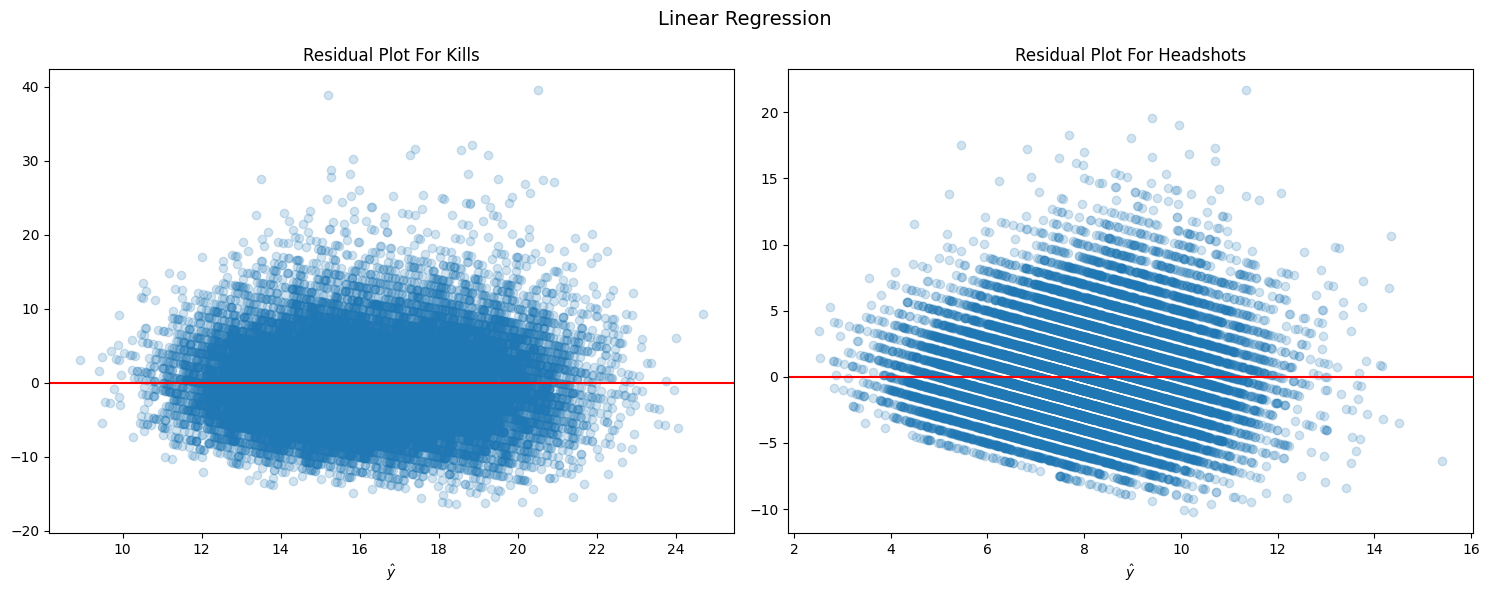

In [54]:
lr, r2, mae, rmse, y_pred_lr = model_scores(lr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lr, y_test, "Linear Regression")

Mean Absolute Error (Kills): 4.485666474384171
Mean Absolute Error (Headshots): 2.803738773814943
Root Mean Squared Error (Kills): 5.768918834547908
Root Mean Squared Error (Headshots): 3.5761543421594304


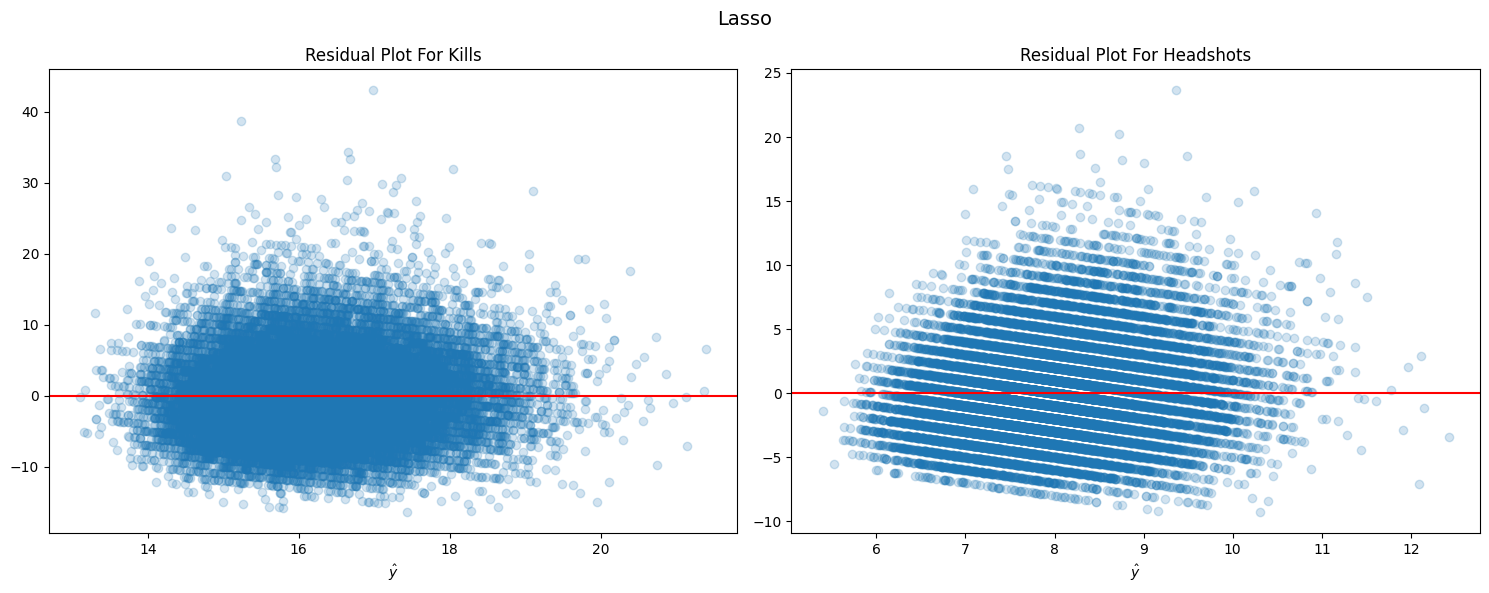

In [55]:
lasso, r2, mae, rmse, y_pred_lasso = model_scores(lasso, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lasso, y_test, "Lasso")

Mean Absolute Error (Kills): 6.113884236755035
Mean Absolute Error (Headshots): 3.839589886034067
Root Mean Squared Error (Kills): 7.832709217591916
Root Mean Squared Error (Headshots): 4.9337715835165525


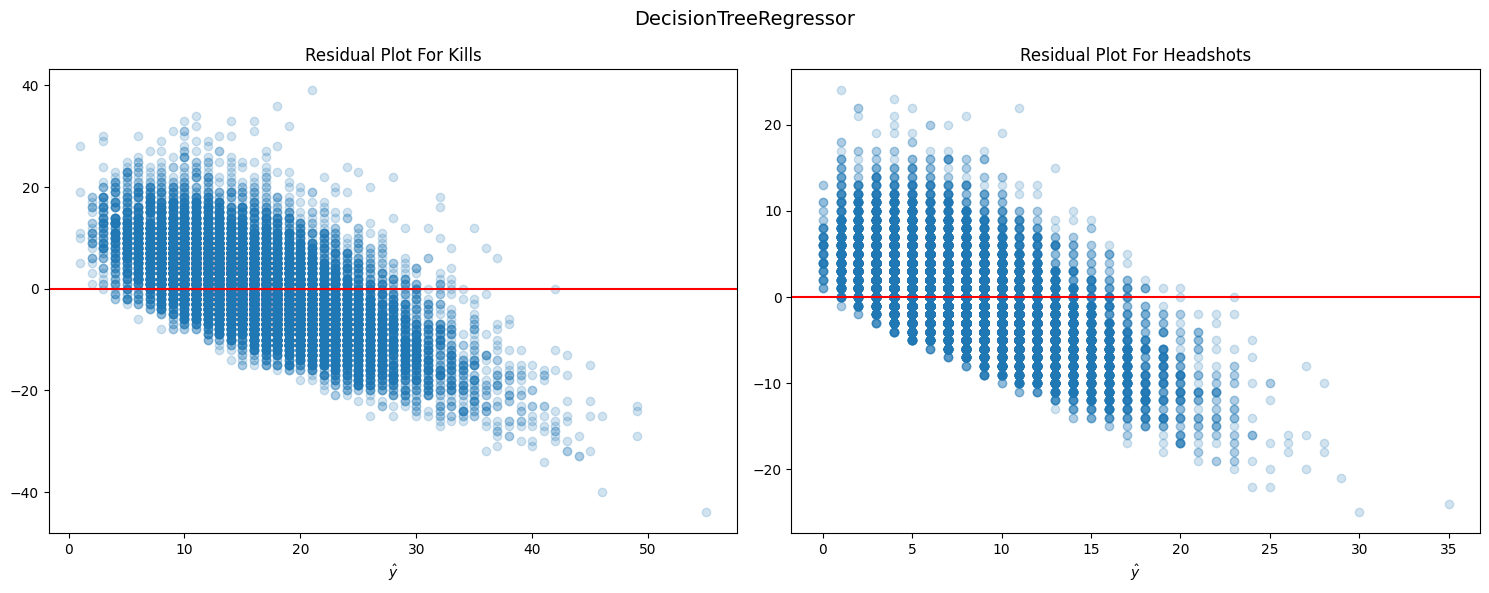

In [56]:
dtr, r2, mae, rmse, y_pred_dtr = model_scores(dtr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_dtr, y_test, "DecisionTreeRegressor")

Mean Absolute Error (Kills): 4.209430523934666
Mean Absolute Error (Headshots): 2.6968102842748305
Root Mean Squared Error (Kills): 5.390833190701947
Root Mean Squared Error (Headshots): 3.4421011285197114


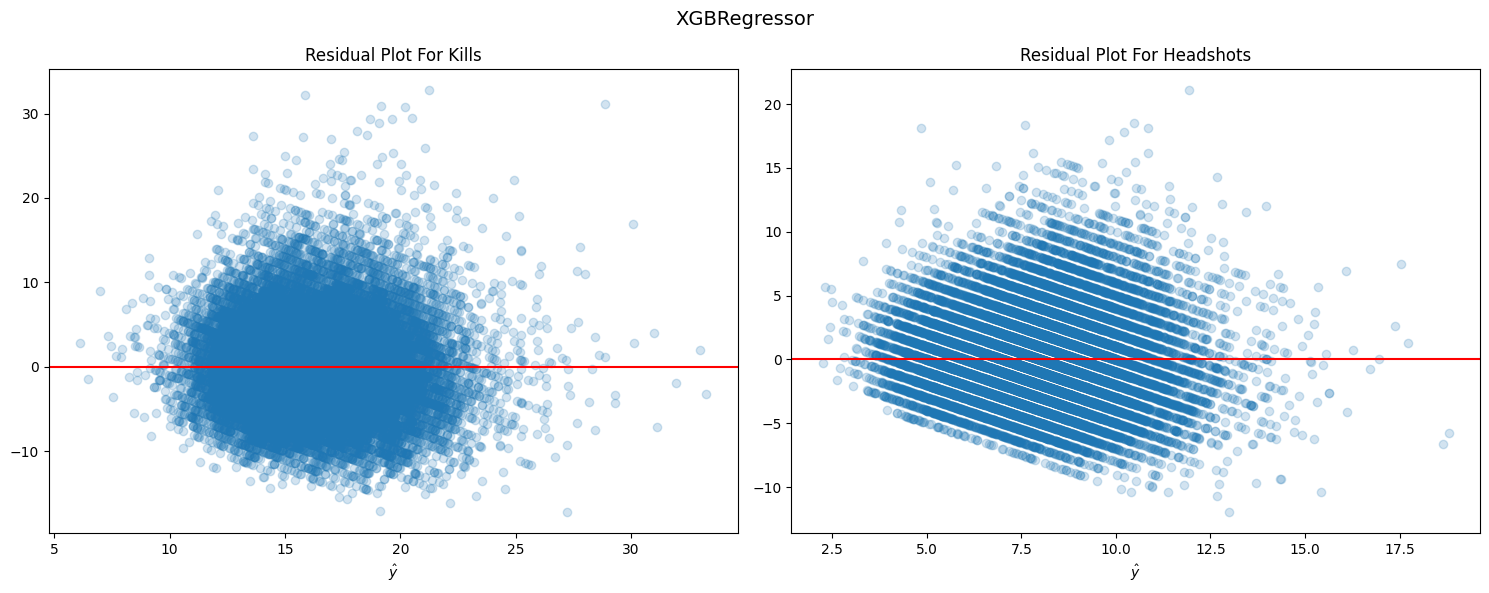

In [57]:
xgr, r2, mae, rmse, y_pred_xgr = model_scores(xgr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_xgr, y_test, "XGBRegressor")

## Model Optimization

In [58]:
# Initalize the grid with all the parameters
grid_params = {
    "max_depth": np.arange(1, 11),
    "gamma": np.linspace(0, 10, 11),
    "subsample": np.linspace(0.1, 1, 10),
    "eta": np.linspace(0.01, 0.3, 10),
    "lambda": np.linspace(0, 10, 5),
    "alpha": np.linspace(0, 10, 5),

    "booster": ["gbtree", "dart", "gblinear"],
    "objective": ["reg:squarederror", "reg:squaredlogerror", "reg:pseudohubererror", "reg:absoluteerror"],
    "eval_metric": ["rmse", "rmsle", "mae", "mape"],
    "tree_method": ["auto", "exact", "approx", "hist"]
}

# Find the best parameters for this model
xgrb = RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=grid_params, cv=10, verbose=1, n_jobs=-1, random_state=42)

# Fit the training data
xgrb.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                        'gamma': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                                        'lambda': array([ 0. ,  2.5,  5. ,  7.5, 10. ]),
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'objective': ['reg:squarederror',
                                                      'reg:squaredlogerror',
                                                      'reg:pseudohubererror',
                                                      'reg:absoluteerror'],
                                        'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist']},
                   random_state=42, verbose=1)

Mean Absolute Error (Kills): 4.2389128269613
Mean Absolute Error (Headshots): 2.683809206184913
Root Mean Squared Error (Kills): 5.478662912497579
Root Mean Squared Error (Headshots): 3.455921590397569


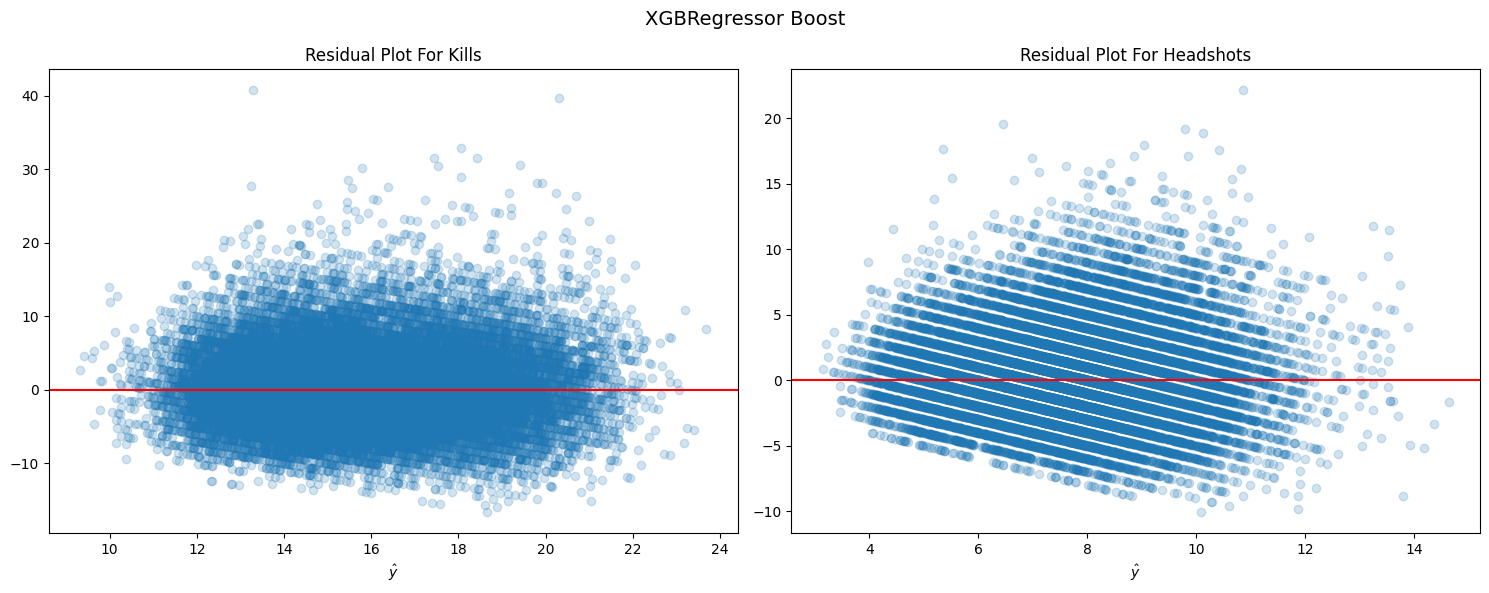

In [59]:
# Evaluate the boosted regression model
xgrb, r2, mae, rmse, y_pred_xgrb = model_scores(xgrb, x_train, y_train, x_test, y_test, True)
plot_residuals(y_pred_xgrb, y_test, "XGBRegressor Boost")

In [68]:
# Save the boosted model
joblib.dump(xgrb, "xgrb.joblib")

['xgrb.joblib']

## Create Buckets (Extra)

In [60]:
# Bucket players
def bucket_players(name: str, year: int):
    if year == 2023:
        ranks = top_players_2023
    else:
        ranks = top_players_2024
    idxs = [5, 10, 25, 50, 100, 200, 250, 300]
    for idx in idxs:
        if name in ranks[:idx]:
            return f"Top {idx}"
    return f"Not Top {idxs[-1]}"

# Apply the function to all the player name columns
cs_stats_wma["Teammate Bucket"] = cs_stats_wma.apply(lambda record: bucket_players(record["Name"], record["Year"]), axis=1)

# Loop through teammates and opponents
for num in range(1, 6):
    if num != 5:
        # When the number is not 5 apply this function
        cs_stats_wma[f"Teammate {num} Bucket"] = cs_stats_wma.apply(lambda record: bucket_players(record[f"Teammate {num}"], record["Year"]), axis=1)
    # Apply this no matter what
    cs_stats_wma[f"Opponent {num} Bucket"] = cs_stats_wma.apply(lambda record: bucket_players(record[f"Opponent {num}"], record["Year"]), axis=1)

cs_stats_wma.head()

,Month,Year,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Teammate Bucket,Teammate 1 Bucket,Opponent 1 Bucket,Teammate 2 Bucket,Opponent 2 Bucket,Teammate 3 Bucket,Opponent 3 Bucket,Teammate 4 Bucket,Opponent 4 Bucket,Opponent 5 Bucket
0,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,lov1kus,17,10,4,...,Top 100,Top 200,Top 200,Top 100,Top 200,Top 200,Top 200,Not Top 300,Not Top 300,Not Top 300
1,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,FenomeN,12,3,1,...,Top 100,Top 100,Top 200,Top 200,Top 200,Top 200,Top 200,Not Top 300,Not Top 300,Not Top 300
2,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,sstiNiX,15,8,5,...,Top 200,Top 100,Top 200,Top 200,Top 200,Top 100,Top 200,Not Top 300,Not Top 300,Not Top 300
3,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,levantino,12,9,6,...,Not Top 300,Top 100,Top 200,Top 200,Top 200,Top 100,Top 200,Top 200,Not Top 300,Not Top 300
4,September,2024,Ancient,2,CPH Wolves,DMS,szejn,13,6,3,...,Top 200,Not Top 300,Top 200,Top 200,Top 300,Not Top 300,Not Top 300,Top 200,Not Top 300,Not Top 300


In [61]:
# Drop the columns that were put into buckets
cs_stats_wma_buckets = cs_stats_wma.drop(
    columns=[
        'Name', 'Teammate 1', 'Teammate 2', 'Teammate 3', 'Teammate 4',
        'Opponent 1', 'Opponent 2', 'Opponent 3', 'Opponent 4', 'Opponent 5'
        ]
)
cs_stats_wma_buckets.head()

,Month,Year,Map,Map Number,Team,Opponent Team,Kills,Headshots,Assists,Deaths,...,Teammate Bucket,Teammate 1 Bucket,Opponent 1 Bucket,Teammate 2 Bucket,Opponent 2 Bucket,Teammate 3 Bucket,Opponent 3 Bucket,Teammate 4 Bucket,Opponent 4 Bucket,Opponent 5 Bucket
0,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,17,10,4,11,...,Top 100,Top 200,Top 200,Top 100,Top 200,Top 200,Top 200,Not Top 300,Not Top 300,Not Top 300
1,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,12,3,1,12,...,Top 100,Top 100,Top 200,Top 200,Top 200,Top 200,Top 200,Not Top 300,Not Top 300,Not Top 300
2,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,15,8,5,13,...,Top 200,Top 100,Top 200,Top 200,Top 200,Top 100,Top 200,Not Top 300,Not Top 300,Not Top 300
3,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,12,9,6,14,...,Not Top 300,Top 100,Top 200,Top 200,Top 200,Top 100,Top 200,Top 200,Not Top 300,Not Top 300
4,September,2024,Ancient,2,CPH Wolves,DMS,13,6,3,16,...,Top 200,Not Top 300,Top 200,Top 200,Top 300,Not Top 300,Not Top 300,Top 200,Not Top 300,Not Top 300


In [62]:
# Bucket teams
def bucket_teams(team: str, year: int):
    if year == 2023:
        ranks = top_teams_2023
    else:
        ranks = top_teams_2024
    idxs = [10, 20, 30, 40, 50]
    for idx in idxs:
        if team in ranks[:idx]:
            return f"Top {idx}"
    return f"Not Top {idxs[-1]}"

# Apply the function to both team name columns
cs_stats_wma_buckets["Team"] = cs_stats_f.apply(lambda record: bucket_teams(record["Team"], record["Year"]), axis=1)
cs_stats_wma_buckets["Opponent Team"] = cs_stats_f.apply(lambda record: bucket_teams(record["Opponent Team"], record["Year"]), axis=1)
cs_stats_wma_buckets.head()

,Month,Year,Map,Map Number,Team,Opponent Team,Kills,Headshots,Assists,Deaths,...,Teammate Bucket,Teammate 1 Bucket,Opponent 1 Bucket,Teammate 2 Bucket,Opponent 2 Bucket,Teammate 3 Bucket,Opponent 3 Bucket,Teammate 4 Bucket,Opponent 4 Bucket,Opponent 5 Bucket
0,September,2024,Anubis,1,Not Top 50,Not Top 50,17,10,4,11,...,Top 100,Top 200,Top 200,Top 100,Top 200,Top 200,Top 200,Not Top 300,Not Top 300,Not Top 300
1,September,2024,Anubis,1,Not Top 50,Not Top 50,12,3,1,12,...,Top 100,Top 100,Top 200,Top 200,Top 200,Top 200,Top 200,Not Top 300,Not Top 300,Not Top 300
2,September,2024,Anubis,1,Not Top 50,Not Top 50,15,8,5,13,...,Top 200,Top 100,Top 200,Top 200,Top 200,Top 100,Top 200,Not Top 300,Not Top 300,Not Top 300
3,September,2024,Anubis,1,Not Top 50,Not Top 50,12,9,6,14,...,Not Top 300,Top 100,Top 200,Top 200,Top 200,Top 100,Top 200,Top 200,Not Top 300,Not Top 300
4,September,2024,Ancient,2,Not Top 50,Not Top 50,13,6,3,16,...,Top 200,Not Top 300,Top 200,Top 200,Top 300,Not Top 300,Not Top 300,Top 200,Not Top 300,Not Top 300


## Statistical Test (Extra)

- **One-way ANOVA**: Determine whether there are any statistically significant differences between the means of three or more independent (unrelated groups).

In [63]:
# Perform the ANOVA test on each map and look at the kills
groups = cs_stats_f.groupby("Map")["Kills"].apply(list)
f, p = f_oneway(*groups)
print(f"pvalue: {p}")

if p < 0.05:
    print("There is a significant difference in the means")
else:
    print("There is no significant difference in the means")

pvalue: 4.3465536893971746e-139
There is a significant difference in the means


In [64]:
# Perform the ANOVA test on a single player (Tauson)
groups = tauson_data.groupby("Map")["Kills"].apply(list)
f, p = f_oneway(*groups)
print(f"pvalue: {p}")

if p < 0.05:
    print("There is a significant difference in the means")
else:
    print("There is no significant difference in the means")

pvalue: 0.8639029751720086
There is no significant difference in the means


## Linear Regression Model Test (Extra)

In [65]:
# Subset the data to only numbers
data = cs_stats.select_dtypes(["int", "float"]).drop(columns=["Team Score", "Opponent Score"]).dropna()

# Independent and dependent variables
X = data.drop(["Kills", "Headshots", "Assists", "Deaths"], axis=1)
y = data["Kills"]

# Add a constant to the model
X = sm.add_constant(X)

# Create the model
lr = sm.OLS(y, X).fit()

# Summarize the model
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Kills   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                 7.331e+04
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:12:01   Log-Likelihood:            -7.7820e+05
No. Observations:              273230   AIC:                         1.556e+06
Df Residuals:                  273225   BIC:                         1.556e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7542      0.078    226.930      0.0

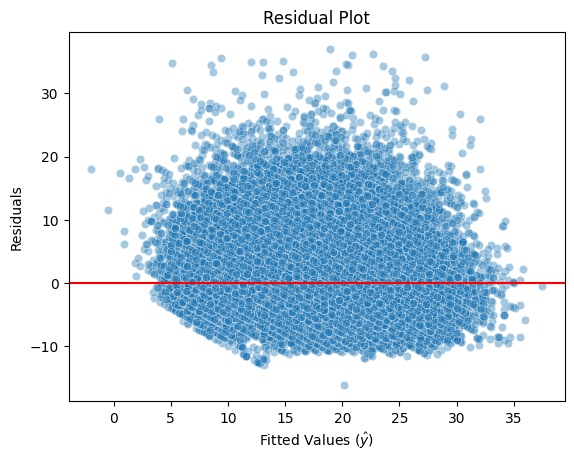

In [66]:
sns.scatterplot(x=lr.fittedvalues, y=lr.resid, alpha=0.40)
plt.axhline(0, c="r")
plt.title("Residual Plot")
plt.xlabel(f"Fitted Values ($\hat{{y}}$)")
plt.ylabel("Residuals")
plt.show()